# MODELLI LINEARI

I modelli lineari utilizzati saranno modelli ARIMA e modelli UCM.

Nella maggior parte delle aziende manufatturiere, l'analisi delle serie storiche guida le attività fondamentali di pianificazione aziendale, approvvigionamento e produzione. 
Eventuali errori nelle previsioni si propagheranno lungo tutta la catena di fornitura o in qualsiasi contesto aziendale. Quindi è importante ottenere previsioni accurate per risparmiare sui costi ed è fondamentale per il successo.

Non solo nella produzione, le tecniche ed i concetti alla base della previsione delle serie temporali sono applicabili in qualsiasi azienda.

Ora la previsione di una serie temporale può essere sostanzialmente suddivisa in due tipi.

Se si utilizzano solo i valori precedenti della serie storica per prevederne i valori futuri, si parla di previsione di serie storica univariata.

E se si utilizzano predittori diversi dalle serie (note anche come variabili esterne) per fare previsioni, si parla di previsione multivariata delle serie temporali.

ARIMA, abbreviazione di "AutoRegressive Integrated Moving Average", è un algoritmo di previsione basato sull'idea che le informazioni nei valori passati delle serie temporali possono essere utilizzate da sole per prevedere i valori futuri.

Caricamento delle librerie, path e dataset

In [1]:
# import necessary libraries
import os
import pandas as pd
import re
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Themes
# "seaborn", 'ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none'
pio.templates.default = "presentation" 

from plotly.subplots import make_subplots

In [120]:
# select data folder_dati
glob_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)
folder_dati = glob_path+R"//dati"
folder_risultati = glob_path+R"//risultati"

In [121]:
files = os.listdir(folder_risultati)
files[0:]

['df_hour.csv',
 'shampoo.csv',
 'prediction_fourier.csv',
 'df_grouped_date.csv',
 'df_grouped_date_risorsa.csv',
 'df_grouped_hour.csv',
 'export.csv',
 'lower_fourier.csv',
 'upper_fourier.csv',
 'df_grouped_date_cama_nosunday.csv',
 'df_grouped_date_cliente.csv',
 'export.xlsx',
 'df_min_ciclo_nosunday_no0.csv',
 'df_grouped_date_nosunday.csv']

In [122]:
# Load export.csv, original file
df = pd.read_csv(folder_risultati+"/export.csv", sep = ",")

In [123]:
# substitute null values with 0
df['Minuti ciclo'] = df['Minuti ciclo'].fillna(0)
df['Minuti NO ciclo'] = df['Minuti NO ciclo'].fillna(0)
df['Efficienza'] = df['Efficienza'].fillna(0)

# convert Date 
df['Date'] = pd.to_datetime(df["Date"], format='%Y-%m-%d')

# convert minuti ciclo, no ciclo, efficienza to double
df['Minuti ciclo'] = df['Minuti ciclo'].replace(',', '.', regex=True).astype(float)
df['Minuti NO ciclo'] = df['Minuti NO ciclo'].replace(',', '.', regex=True).astype(float)
df['Efficienza'] = df['Efficienza'].replace(',', '.', regex=True).astype(float)

In [124]:
df_grouped_date = df.groupby(['Date'])['Minuti ciclo', 'Minuti NO ciclo'].sum().reset_index()
df_grouped_date['Efficienza'] = df_grouped_date['Minuti ciclo'] / (df_grouped_date['Minuti ciclo'] + 
                                                                   df_grouped_date['Minuti NO ciclo'])

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [125]:
###################### CLIENTE

cliente = 'CAMA'

df_cliente = df

df_cliente = df_cliente[df_cliente['CLIENTE'] == cliente]

df_grouped_date_cliente = df_cliente.groupby(['Date'])['Minuti ciclo', 'Minuti NO ciclo'].sum().reset_index()

# create field date
df_days = pd.DataFrame({'Date': df_grouped_date.Date})
merged = pd.merge(df_days, df_grouped_date_cliente, on=['Date'], how='left')
df_grouped_date_cliente = merged.fillna(0)

# days per week
eff_week = df_grouped_date_cliente
eff_week['Giorno'] = eff_week['Date'].dt.strftime("%A")
df_grouped_date_cliente = eff_week

# delete sundays
df_grouped_date_cliente = df_grouped_date_cliente[df_grouped_date_cliente['Giorno'] != "Sunday"]

# i valori a 0 sono un po... sostituisco con media
df_grouped_date_cliente['Minuti ciclo'] = df_grouped_date_cliente['Minuti ciclo'].mask(df_grouped_date_cliente['Minuti ciclo']==0).fillna(df_grouped_date_cliente['Minuti ciclo'].mean())

df_grouped_date_cliente.to_csv(folder_risultati + '//df_grouped_date_cliente.csv', decimal = ',', index = False)

df_grouped_date_cliente

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Minuti ciclo,Minuti NO ciclo,Giorno
0,2019-01-01,176.883227,0.0,Tuesday
1,2019-01-02,176.883227,0.0,Wednesday
2,2019-01-03,176.883227,0.0,Thursday
3,2019-01-04,176.883227,0.0,Friday
4,2019-01-05,176.883227,0.0,Saturday
...,...,...,...,...
725,2020-12-26,176.883227,0.0,Saturday
727,2020-12-28,176.883227,0.0,Monday
728,2020-12-29,176.883227,0.0,Tuesday
729,2020-12-30,176.883227,0.0,Wednesday


In [126]:
df_grouped_risorsa = df.groupby(['Date', 'Risorsa'])['Minuti ciclo', 'Minuti NO ciclo'].sum().reset_index()
df_grouped_risorsa['Efficienza'] = df_grouped_risorsa['Minuti ciclo'] / (df_grouped_risorsa['Minuti ciclo'] + 
                                                                         df_grouped_risorsa['Minuti NO ciclo'])

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [127]:
df_grouped_date.to_csv(folder_risultati + '\\df_grouped_date.csv', decimal = ',', index = False)
df_grouped_risorsa.to_csv(folder_risultati + '\\df_grouped_date_risorsa.csv', decimal = ',', index = False)

In [128]:
grouped_vtc530 = df_grouped_risorsa[df_grouped_risorsa['Risorsa'] == "MAZAK-VTC530"]
grouped_vtc800 = df_grouped_risorsa[df_grouped_risorsa['Risorsa'] == "MAZAKVTC800"]
grouped_j600= df_grouped_risorsa[df_grouped_risorsa['Risorsa'] == "MAZAKJ600"]
grouped_2014 = df_grouped_risorsa[df_grouped_risorsa['Risorsa'] == "MAZAK2014"]
grouped_2015 = df_grouped_risorsa[df_grouped_risorsa['Risorsa'] == "MAZAK2015"]

In [129]:
# Now divide also by hour
df['Hour'] = df['KEY'].str.rpartition('_')[2]

In [130]:
df.head()

,KEY,Risorsa,CODART,Count,Minuti ciclo,Minuti NO ciclo,Efficienza,Date,CLIENTE,Hour
0,2019_1_1_6,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01,NaN,6
1,2019_1_1_7,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01,NaN,7
2,2019_1_1_8,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01,NaN,8
3,2019_1_1_9,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01,NaN,9
4,2019_1_1_10,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01,NaN,10


In [131]:
# new format of date
df_hour = df
df_hour['Date'] = pd.to_datetime(df['KEY'].str.split('_').str[0] + "/" +
                                              df['KEY'].str.split('_').str[1] + "/" +
                                              df['KEY'].str.split('_').str[2] + " " +
                                              df['Hour'] + ":00:00", format='%Y/%m/%dT%H:%M:%S')

In [132]:
df_hour.head()

,KEY,Risorsa,CODART,Count,Minuti ciclo,Minuti NO ciclo,Efficienza,Date,CLIENTE,Hour
0,2019_1_1_6,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01 06:00:00,NaN,6
1,2019_1_1_7,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01 07:00:00,NaN,7
2,2019_1_1_8,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01 08:00:00,NaN,8
3,2019_1_1_9,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01 09:00:00,NaN,9
4,2019_1_1_10,MAZAK-VTC530,NaN,NaN,0.0,0.0,0.0,2019-01-01 10:00:00,NaN,10


In [133]:
df_grouped_hour = df_hour.groupby(['Date'])['Minuti ciclo', 'Minuti NO ciclo'].sum().reset_index()
df_grouped_hour['Efficienza'] = df_grouped_hour['Minuti ciclo'] / (df_grouped_hour['Minuti ciclo'] + 
                                                                   df_grouped_hour['Minuti NO ciclo'])

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [134]:
# Efficiency per week
eff_week = df_grouped_date
eff_week['Giorno'] = eff_week['Date'].dt.strftime("%A")
df_grouped_date = eff_week

In [135]:
fig = px.box(eff_week, x="Giorno", y="Efficienza", color="Giorno")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

Dal grafico soprastante si evince che mediamente l'efficienza delle macchine cresce al crescere dei giorni nella settimana.

In [136]:
# delete sundays
df_grouped_date = df_grouped_date[df_grouped_date['Giorno'] != "Sunday"]

In [137]:
df_grouped_date.to_csv(folder_risultati + '\\df_grouped_date_nosunday.csv', decimal = ',', index = False)

In [138]:
# plot general efficiency
fig = px.line(df_grouped_date_cliente, x = "Date", y = "Minuti ciclo", 
              title = "minuti ciclo cliente / gg")
fig.show()

### Grafici e visualizzazioni

I grafici saranno della serie di dati raggruppata per giorno e per ora

In [139]:
# plot general efficiency
fig = px.line(df_grouped_date, x = "Date", y = "Efficienza", 
              title = "Efficienza / giorno Totale delle macchine")
fig.show()

Dal primo grafico si può notare il trend crescente che ha portato l'efficienza media delle macchine dal 30% al 45% nel giro di un anno e mezzo!

Per quanto riguarda la stagionalità, è presente nel senso che la domenica le macchine non lavorano, mentre al sabato lavorano soltanto 5/6 ore: dunque si ha una stagionalità settimanale.

In [140]:
# plot general efficiency per hour
fig = px.line(df_grouped_hour, x = "Date", y = "Efficienza", 
              title = "Efficienza / giorno Totale delle macchine")
fig.show()

Anche dal grafico orario si intravede un trend crescente da inizio 2019 fino a metà 2020.

In questo caso la stagionalità è rappresentata prima dai periodi 6-22 di lavoro della macchina, poi dalla stagionalità settimanale prima citata.

In questo grafico vengono evidenziate meglio i due periodi di chiusura aziendale, coincidenti con la chiusura natalizia (21 dicembre - 2 gennaio compresi) e la chiusura causa pandemia da COVID-19 (19 - 31 marzo compresi)

In [141]:
# plot general efficiency per day and macchine
fig = px.line(df_grouped_risorsa, x = "Date", y = "Efficienza",  color = "Risorsa", 
              title = "Efficienza / giorno Totale delle macchine")
fig.show()

In [142]:
# plot Minuti ciclo general
fig = px.line(df_grouped_date, x = "Date", y = "Minuti ciclo", 
              title = "Minuti ciclo / giorno")
fig.show()

In [143]:
# plot Minuti NO ciclo general
fig = px.line(df_grouped_date, x = "Date", y = "Minuti NO ciclo", 
              title = "Minuti NO ciclo / giorno")
fig.show()

In [144]:
# save
df_grouped_hour.to_csv(folder_risultati + '\\df_grouped_hour.csv', decimal = ',', index = False)
df_hour.to_csv(folder_risultati + '\\df_hour.csv', decimal = ',', index = False)

Viene effettuata una decomposizione delle componenti della serie storica

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose

# crea la serie storica
ts = df_grouped_date[['Date', 'Minuti ciclo']]
ts.Date = pd.to_datetime(ts.Date)
ts.set_index('Date', inplace=True, drop=True)
ts['Minuti ciclo'] = ts['Minuti ciclo'].fillna(0)

decompose_efficiency = seasonal_decompose(ts['Minuti ciclo'], model='additive', freq=7)

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



In [146]:
print(ts.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 627 entries, 2019-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Minuti ciclo  627 non-null    float64
dtypes: float64(1)
memory usage: 9.8 KB
None


/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



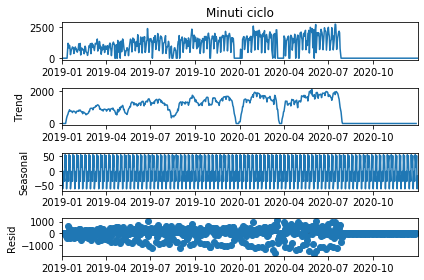

In [147]:
# Plot
decompose_efficiency.plot().show()

Le componenti decomposte mostrano un trend comunque crescente, con una stagionalità settimanale.

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [149]:
# esporto solo i dati che mi interessano
ts_f = ts[:491]

# i valori a 0 sono 57, contando nnn gg di chiusura aziendale + le varie festività nel giro di due anni ci sta! Li sostituisco con la media!
ts_f['Minuti ciclo'] = ts_f['Minuti ciclo'].mask(ts_f['Minuti ciclo']==0).fillna(ts_f['Minuti ciclo'].mean())

# train e test.....
train_end = datetime(2019,12,31)
test_end = datetime(2020,7,23)

train = ts_f[:train_end]
test = ts_f[train_end + timedelta(days=1):test_end]

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## MODELLO ARIMA

ARIMA, abbreviazione di "Auto Regressive Integrated Moving Average" è in realtà una classe di modelli che spiega una data serie temporale in base ai propri valori passati, ovvero i propri ritardi e gli errori di previsione ritardati, in modo che sia possibile utilizzare l'equazione per prevedere i valori futuri.

Qualsiasi serie temporale "non stagionale" che mostri schemi e non sia un white noise può essere modellata con i modelli ARIMA.

Un modello ARIMA è caratterizzato da 3 termini: p, d, q

- p è l'ordine del termine AR

- q è l'ordine del termine MA

- d è il numero di differenze necessarie per rendere stazionaria la serie temporale

Se una serie temporale presenta modelli stagionali, è necessario aggiungere termini stagionali e diventa SARIMA, abbreviazione di "ARIMA stagionale".

Il primo passo per costruire un modello ARIMA è rendere stazionarie le serie temporali; questo perché il termine "Regressione automatica" in ARIMA significa che si tratta di un modello di regressione lineare che utilizza i propri ritardi come predittori.
I modelli di regressione lineare funzionano meglio quando i predittori non sono correlati e sono indipendenti l'uno dall'altro.

Per rendere stazionaria la serie, l'approccio più comune è quello di differenziarla. Cioè, sottrai il valore precedente dal valore corrente. A volte, a seconda della complessità della serie, potrebbe essere necessaria più di una differenziazione.

Il valore di d, quindi, è il numero minimo di differenze necessarie per rendere stazionaria la serie. E se la serie temporale è già stazionaria, allora d = 0.

Per quanto riguarda gli altri termini, "p" è l'ordine del termine "Auto Regressive" (AR). Si riferisce al numero di ritardi di Y da utilizzare come predittori; "q" è l'ordine del termine "Media mobile" (MA). Si riferisce al numero di errori di previsione ritardati che dovrebbero entrare nel modello ARIMA.

##### TROVARE L'ORDINE d

Lo scopo di differenziare la serie è quello di renderla stazionaria.

Differenziare troppo la serie potrebbe essere una cosa negativa, in quanto una serie troppo differenziata può essere nuovamente stazionaria.

Il giusto ordine di differenziazione è la differenza minima richiesta per ottenere una serie quasi stazionaria che si aggira intorno a una media definita e il grafico ACF raggiunge lo zero abbastanza rapidamente.

Se le autocorrelazioni sono positive per molti numeri di ritardi (10 o più), la serie necessita di ulteriori differenze. D'altra parte, se la stessa autocorrelazione del ritardo 1 è troppo negativa, la serie è probabilmente eccessivamente differenziata.

Per prima cosa si verifica che la serie è stazionaria, usando l'Augmented Dickey Fuller Test. Nel caso in cui la serie sia stazionaria, non sarà necessaria la differenziazione e d sarà uguale a 0.

L'ipotesi nulla del test ADF è che la serie temporale non sia stazionaria. Quindi, se il valore p del test è inferiore al livello di significatività (0,05), si rifiuta l'ipotesi nulla e si deduce che la serie temporale è effettivamente stazionaria.


Per calcolare l'ACF elimino i valori nulli, considerando solo i valori numerici.

In [150]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

# ts_na = df_grouped_date[['Date', 'Minuti ciclo']]

result = adfuller(ts_f['Minuti ciclo'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.722744
p-value: 0.419434


Il p-value è maggiore del livello di significatività. A questo punto, procedo con la differenziazione.

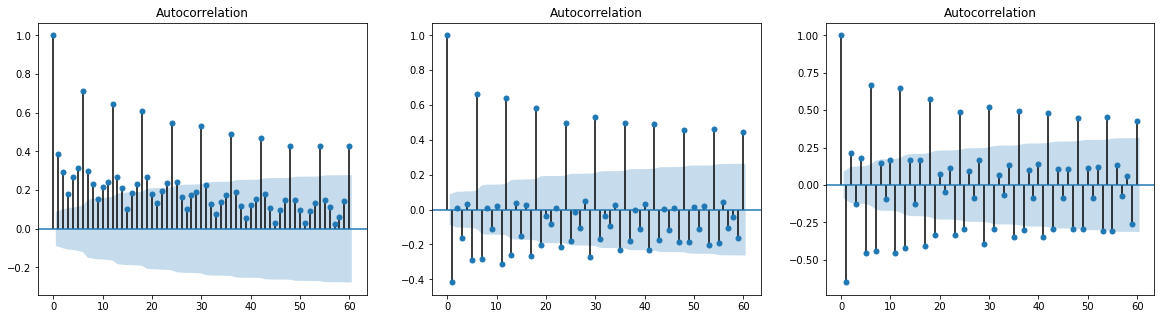

In [151]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# pyplot.figure(figsize=(12,5), dpi=100)
# plot_acf(ts_na['Minuti ciclo'].dropna(), lags = 200)
# pyplot.show()
# plot_acf(ts_na['Minuti ciclo'].diff().dropna(), lags = 200)
# pyplot.show()
# plot_acf(ts_na['Minuti ciclo'].diff().diff().dropna(), lags = 200)
# pyplot.show()

#print if you want to visualize
#print(dta.head())

fig, ax = plt.subplots(1,3,figsize=(20,5))
sm.graphics.tsa.plot_acf(ts_f['Minuti ciclo'].dropna(), lags=60, ax=ax[0])
sm.graphics.tsa.plot_acf(ts_f['Minuti ciclo'].diff().dropna(), lags=60, ax=ax[1])
sm.graphics.tsa.plot_acf(ts_f['Minuti ciclo'].diff().diff().dropna(), lags=60, ax=ax[2])
plt.show()

Raggiunge la stazionarietà con 1 differenza. Infatti con 2 differenze i primi lag sono molto più marcati, quindi considero solo 1 differenza!

In [152]:
result = adfuller(ts_f['Minuti ciclo'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.799544
p-value: 0.000000


Ora è differenziata

##### TROVARE L'ORDINE p

Il passaggio successivo consiste nell'identificare se il modello necessita di termini AR. Per scoprirlo, bisogna controllare il grafico PACF.

L'autocorrelazione parziale può essere immaginata come la correlazione tra la serie e il suo ritardo, dopo aver escluso i contributi dai ritardi intermedi. Quindi, PACF trasmette in qualche modo la pura correlazione tra un ritardo e la serie. 

Qualsiasi autocorrelazione in una serie stazionaria può essere rettificata aggiungendo un numero sufficiente di termini AR. Quindi, inizialmente assumiamo che l'ordine del termine AR sia uguale al numero di ritardi che supera il limite di significatività nel grafico PACF.

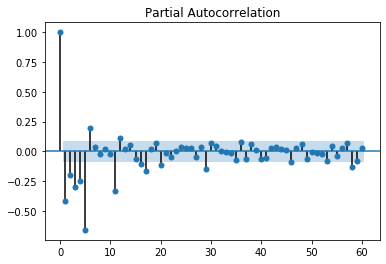

In [153]:
import matplotlib.pyplot as pyplot
plot_pacf(ts_f['Minuti ciclo'].diff().dropna(), lags = 60)
pyplot.show()

il primo lag risulta significativo, come il secondo. Il terzo non risulta molto significativo, quindi fisso il valore di p a 2

##### TROVARE L'ORDINE q

Come per l'ordine p bisogna guardare la PACF, per definire l'ordine q (MA) bisogna visualizzare la ACF.

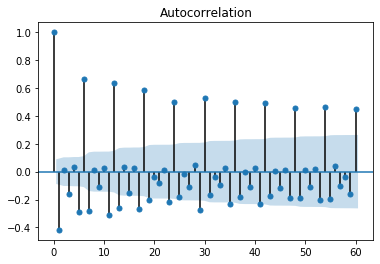

In [154]:
plot_acf(ts_f['Minuti ciclo'].diff().dropna(), lags = 60)
pyplot.show()

Il primo ed il secondo lag sono fuori dagli intervalli di confidenza, quindi considero q = 2.

### MODELLO ARIMA
Ora che sono stati definiti i valori p, d, q, viene implementato il modello ARIMA.

In [155]:
from statsmodels.tsa.arima_model import ARIMA

# 2,1,2 ARIMA Model
model1 = ARIMA(ts_f['Minuti ciclo'], order=(6,1,2))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:         D.Minuti ciclo   No. Observations:                  490
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -3572.374
Method:                       css-mle   S.D. of innovations            353.375
Date:                Fri, 23 Oct 2020   AIC                           7164.748
Time:                        16:00:59   BIC                           7206.692
Sample:                             1   HQIC                          7181.221
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0983      4.259      0.258      0.796      -7.249       9.446
ar.L1.D.Minuti ciclo    -1.2710      0.180     -7.064      0.000      -1.624      -0.918
ar.L2.D.Minu

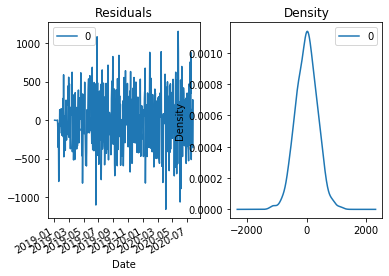

In [156]:
import matplotlib.pyplot as plt

# Plot residual errors
residuals = pd.DataFrame(model1_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

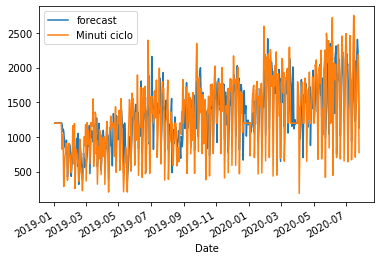

In [157]:
# plot real vs fitted
model1_fit.plot_predict(dynamic=False)
plt.show()

In [158]:
fc_train_series1 = pd.Series(model1_fit.predict(typ='levels'), index=train.index)
fc_train_series1 = fc_train_series1.fillna(fc_train_series1.mean())

# RMSE ON TRAINING
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse1_train  = sqrt(mean_squared_error(train, fc_train_series1))
rmse1_train

327.3661172929128

La tabella dei coefficienti ci dice che il coefficiente dell'AR6 è poco significativo ed il p value (colonna P>|z|) è al di fuori dell'intervallo di confidenza per MA1 ed MA2. Provo un ARIMA(6,1,3)

In [159]:
# 6,1,3 ARIMA Model
model2 = ARIMA(ts_f['Minuti ciclo'], order=(6,1,3))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:         D.Minuti ciclo   No. Observations:                  490
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -3569.925
Method:                       css-mle   S.D. of innovations            351.537
Date:                Fri, 23 Oct 2020   AIC                           7161.849
Time:                        16:01:02   BIC                           7207.988
Sample:                             1   HQIC                          7179.970
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0878      3.842      0.283      0.777      -6.442       8.618
ar.L1.D.Minuti ciclo    -1.0433      0.169     -6.191      0.000      -1.374      -0.713
ar.L2.D.Minu

L'AIC del modello è leggermente diminuito ed è una cosa positiva. I coefficienti di AR ed MA sono significativi per AR1 e MA2, mentre MA1 > 0.05 e quindi non è significativo.

Procedo con la stampa dei residui

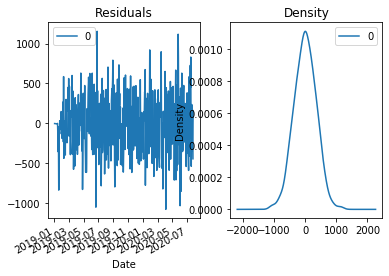

In [160]:
import matplotlib.pyplot as plt

# Plot residual errors
residuals = pd.DataFrame(model2_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

La media è vicina allo zero e la varianza è uniforme.

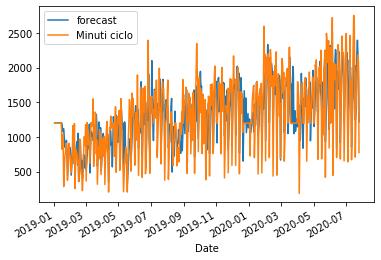

In [161]:
# plot real vs fitted
model2_fit.plot_predict(dynamic=False)
plt.show()

In [162]:
fc_train_series2 = pd.Series(model2_fit.predict(typ='levels'), index=train.index)
fc_train_series2 = fc_train_series2.fillna(fc_train_series2.mean())

# RMSE ON TRAINING
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse2_train  = sqrt(mean_squared_error(train, fc_train_series2))
rmse2_train

326.5121444501468

Una volta identificato il modello, ora effettuiamo la previsione dei valori futuri.

### FORECASTING

In [163]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
# train = ts_f['Minuti ciclo'][:366]
# test = ts_f['Minuti ciclo'][367:571]

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



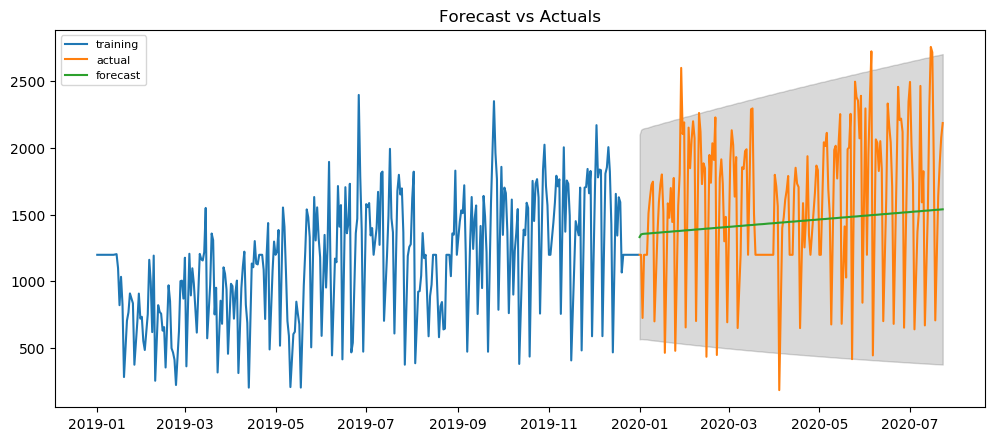

In [164]:
# Build Model
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [165]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms1 = sqrt(mean_squared_error(test, fc_series))
rms1

569.199439721327

La previsione senza la componente stagionale non riesce ad identificare correttamente le previsioni.

Introduco la componente stagionale.

#### SARIMA

Inizialmente provo l'auto.arima, poi sviluppo il modello.

Provo l'auto.arima

In [166]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=6, max_q=3, m=6,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 6); AIC=4369.500, BIC=4388.135, Fit time=0.758 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 6); AIC=4520.294, BIC=4527.748, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 6); AIC=4439.599, BIC=4454.506, Fit time=0.283 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 6); AIC=4394.323, BIC=4409.231, Fit time=0.621 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 6); AIC=4365.297, BIC=4387.658, Fit time=1.346 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 6); AIC=4433.986, BIC=4452.620, Fit time=0.469 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 6); AIC=4366.560, BIC=4392.648, Fit time=2.082 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 6); AIC=4497.300, BIC=4512.208, Fit time=0.152 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 2, 6); AIC=4386.691, BIC=4416.506, Fit time=3.004 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  313
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 6)   Log Likelihood               -2176.648
Date:                           Fri, 23 Oct 2020   AIC                           4365.297
Time:                                   16:01:23   BIC                           4387.658
Sample:                                        0   HQIC                          4374.239
                                           - 313                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5063      1.070      2.343      0.019       0.410       4.603
ar.L1          0.7704      0.087      8.900      0.000       0.601       0.940
ma.L1         -0.5008      0.112     -4.487      0.000      -0.719      -0.282
ar.S.L6        0.1655      0.060      2.775      0.006       0.049       0.282
ma.S.L6       -0.9581      0.028    -34.135      0.000      -1.013      -0.903
sigma2      8.132e+04   6232.406     13.047      0.000    6.91e+04    9.35e+04
===================================================================================
Ljung-Box (Q):                       37.44   Jarque-Bera (JB):                 5.44
Prob(Q):                              0.59   Prob(JB):                         0.07
Heteroskedasticity (H):               1.57   Skew:                             0.25
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

l'auto arima identifica la previsione migliore con un ARIMA(1,0,1)(1,1,1) di periodo 6

In [167]:
# sARIMA Model
sarima_model = SARIMAX(ts_f['Minuti ciclo'], order=(1,0,1), seasonal_order = (1,1,1,6))
sarima_fit = sarima_model.fit(disp=0)

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



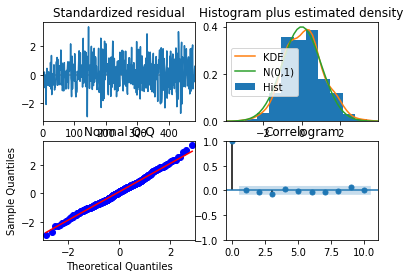

In [168]:
# plot real vs fitted
sarima_fit.plot_diagnostics()
plt.show()

In [169]:
fc_train_series_smodel = pd.Series(sarima_fit.predict(typ='levels'), index=train.index)
fc_train_series_smodel = fc_train_series_smodel.fillna(fc_train_series_smodel.mean())

# RMSE ON TRAINING
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_smodel_train  = sqrt(mean_squared_error(train, fc_train_series_smodel))
rmse_smodel_train

329.37124636170415

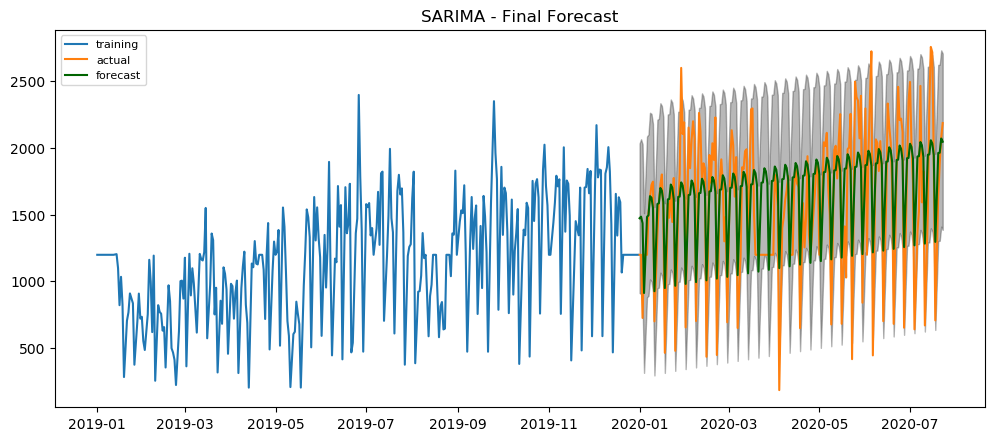

In [170]:
# Forecast
n_periods = len(test)
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(ts['Minuti ciclo'].index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fitted_series, label='forecast', color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title("SARIMA - Final Forecast")
plt.legend(loc='upper left', fontsize=8)
plt.show()

Text(0, 0.5, 'Error')

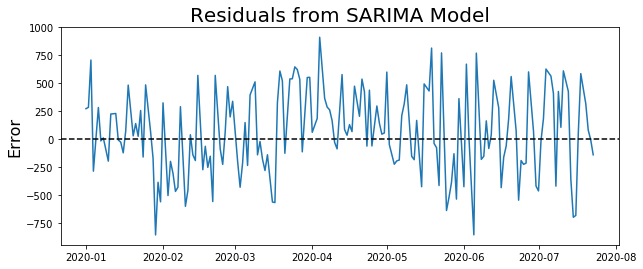

In [171]:
# calcolo residui
residuals = fitted_series - test['Minuti ciclo']
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Le previsioni sono abbastanza buone, si intravede un trend crescente e viene identificata correttamente la stagionalità con picchi negativi al sabato.

In [172]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(test, fitted_series))
rmse_sarima

378.76998669480633

In [173]:
ts_f

,Minuti ciclo
Date,
2019-01-01,1199.102987
2019-01-02,1199.102987
2019-01-03,1199.102987
2019-01-04,1199.102987
2019-01-05,1199.102987
...,...
2020-07-21,1881.433333
2020-07-22,2074.900000
2020-07-23,2184.450000


In [174]:
# save
ts_f.to_csv(folder_risultati + '//df_min_ciclo_nosunday_no0.csv', decimal = ',', index = True)

### SARIMA WITH FOURIER TERMS

In [71]:
# r script process data and generate results

In [203]:
# Load fourier.csv, original file
pre_fourier = pd.read_csv(folder_risultati+"/prediction_fourier.csv", sep = ",").replace('.', ',', regex=True).astype(float)
lower_fourier = pd.read_csv(folder_risultati+"/lower_fourier.csv", sep = ",").replace('.', ',', regex=True).astype(float)
upper_fourier = pd.read_csv(folder_risultati+"/upper_fourier.csv", sep = ",").replace('.', ',', regex=True).astype(float)

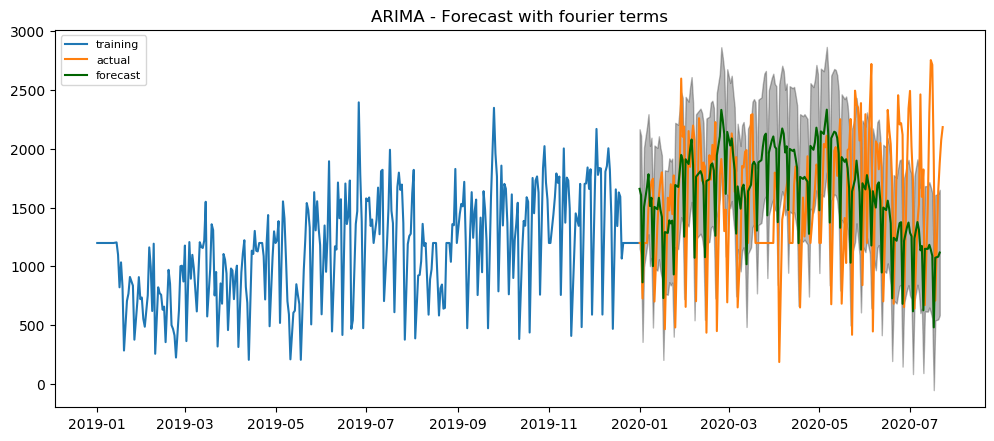

In [204]:
# Forecast
test_2 = test[:-2]
n_periods = len(test_2)
index_of_fc = pd.date_range(ts['Minuti ciclo'].index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(pre_fourier['x'].to_numpy(), index=test_2.index)
lower_series = pd.Series(lower_fourier['x'].to_numpy(), index=test_2.index)
upper_series = pd.Series(upper_fourier['x'].to_numpy(), index=test_2.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fitted_series, label='forecast', color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title("ARIMA - Forecast with fourier terms")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [205]:
rmse_arima_fourier = sqrt(mean_squared_error(test_2, fitted_series))
rmse_arima_fourier

705.8339872276173

In [61]:
# prepare new Fourier terms
exog = pd.DataFrame({'date': ts_f.index})

In [62]:
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='y'))
exog['sin365'] = np.sin(np.pi * exog.index.dayofyear / 313.25)
exog['cos365'] = np.cos(np.pi * exog.index.dayofyear / 313.25)
#exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 313.25)
#exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 313.25)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(ts_f)-178)]
exog_to_test = exog.iloc[(len(ts_f)-176):]

In [63]:
# Fit model
arima_exog_model = pm.auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=6)

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/emanuelecarnati/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zer

In [64]:
# Forecast
fitted, confint = arima_exog_model.predict(n_periods=n_periods, exogenous=exog_to_test, return_conf_int=True)

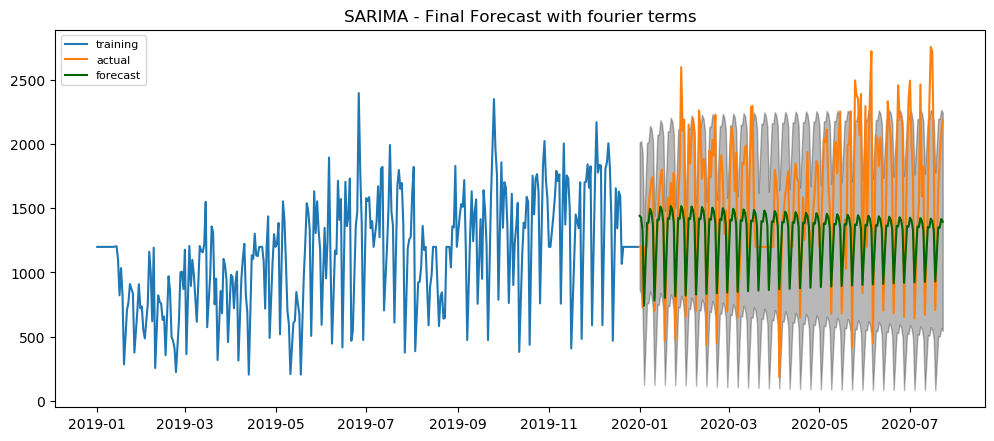

In [65]:
index_of_fc = pd.date_range(ts['Minuti ciclo'].index[-1], periods = n_periods, freq='Y')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fitted_series, label='forecast', color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title("SARIMA - Final Forecast with fourier terms")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [66]:
rmse_sarima_f = sqrt(mean_squared_error(test, fitted_series))
rmse_sarima_f

529.8285390239748